In [1]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import csv data and create a dataframe
df = pd.read_csv("product_sales.csv")

In [3]:
df.head(10)

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois
5,6,Call,6489e678-40f2-4fed-a48e-d0dff9c09205,13,65.01,10,24,Mississippi
6,4,Email,eb6bd5f1-f115-4e4b-80a6-5e67fcfbfb94,11,113.38,9,28,Georgia
7,1,Email,047df079-071b-4380-9012-2bfe9bce45d5,10,99.94,1,22,Oklahoma
8,5,Email,771586bd-7b64-40be-87df-afe884d2af9e,11,108.34,10,31,Massachusetts
9,5,Call,56491dae-bbe7-49f0-a651-b823a01103d8,11,53.82,7,23,Missouri


This project is part of the practical exam to receive a professional data analytics certificate from DataCamp.

We need to know:
- How many customers were there for each approach?
- What does the spread of the revenue look like overall? And for each method?
- Was there any difference in revenue over time for each of the methods?
- Based on the data, which method would you recommend we continue to use? Some
of these methods take more time from the team so they may not be the best for us
to use if the results are similar.

<center><img src='Data_Information.jpg' alt="Data Information"></center>

In [4]:
# Checking for missing values and finding each column data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [5]:
# We can see there are some missing values in the revenue column.
# Let's check each column for data validation and its need for cleaning.

# 1- Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

week                    0
sales_method            0
customer_id             0
nb_sold                 0
revenue              1074
years_as_customer       0
nb_site_visits          0
state                   0
dtype: int64


In [6]:
# 2 - Data validation: Check the unique values to identify any unexpected or erroneous data.
unique_values = df.nunique()
print(unique_values)

week                     6
sales_method             5
customer_id          15000
nb_sold                 10
revenue               6743
years_as_customer       42
nb_site_visits          27
state                   50
dtype: int64


In [7]:
# Check for outliers: Using summary statistics such as mean, median, 
# standard deviation, and quartiles, we can identify outliers in numeric columns.
summary_stats = df.describe().round(2)
print(summary_stats)

           week   nb_sold   revenue  years_as_customer  nb_site_visits
count  15000.00  15000.00  13926.00           15000.00        15000.00
mean       3.10     10.08     93.93               4.97           24.99
std        1.66      1.81     47.44               5.04            3.50
min        1.00      7.00     32.54               0.00           12.00
25%        2.00      9.00     52.47               1.00           23.00
50%        3.00     10.00     89.50               3.00           25.00
75%        5.00     11.00    107.33               7.00           27.00
max        6.00     16.00    238.32              63.00           41.00


There are 1074 missing values in revenue column. In sales_method column we see 5 different method which is wrong (we should have 3 type of methods, and there are outliers in years_as_customer, because the company founded in 1984 and we can't have a customers since 63 years ago

In [8]:
# Proportion of missing values relative to the total entries in the revenue column
(df['revenue'].isna().sum()/df['revenue'].count())*100

7.7121930202498925

There are more than 5 percent missing values in revenue column,  so we can not easily drop them unless we examine randomness of missing values. If they are missing completely at random (MCAR) or missing at random (MAR), dropping them may be less problematic. However, if they are missing not at random (MNAR), dropping them could introduce bias.

In [9]:
# We should have 3 unique values in sales_method column. 
unique_values = df['sales_method'].unique()
print(unique_values)

['Email' 'Email + Call' 'Call' 'em + call' 'email']


In [10]:
# Standardize the values in the 'sales_method' column by replacing 'em + call' with 'Email + Call' and 'email' with 'Email'
# Create a copy of the original DataFrame
df_corrected = df.copy()

# Replace values in the 'sales_method' column
df_corrected['sales_method'] = df['sales_method'].replace({'em + call': 'Email + Call', 'email': 'Email'})

# Check the unique values in the 'sales_method' column after replacement
unique_sales_method = df_corrected['sales_method'].unique()
print("Unique values in the sales_method column after replacement:", unique_sales_method)


Unique values in the sales_method column after replacement: ['Email' 'Email + Call' 'Call']


In [11]:
# Values greater than 40 in years_as_customer are wrong and we should consider them as outliers
df_corrected[df_corrected['years_as_customer']>40]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
13741,2,Email,18919515-a618-430c-9a05-2c7d8fea96af,10,97.22,63,24,California
13800,4,Call,2ea97d34-571d-4e1b-95be-fea1c404649f,10,50.47,47,27,California


In [12]:
# There are only two records as years_as_customer outliers, so we can easily drop them.
# Filter records where 'years_as_customer' is less than or equal to 40
df_filtered = df_corrected[df_corrected['years_as_customer'] <= 40]

# Check the number of records before and after filtering
print("Number of records before filtering:", len(df_corrected))
print("Number of records after filtering:", len(df_filtered))


Number of records before filtering: 15000
Number of records after filtering: 14998


In [13]:
# To conduct a statistical test to determine if there is a relationship between missing values in the 'revenue' 
# column and the 'sales_method' column, we can use a chi-square test of independence. This test is appropriate 
# when both variables are categorical, so we first create a categorical revenue column.

# Replace NaN values with "Null" and non-NaN values with "Not_Null"
df_filtered['revenue_category'] = df_filtered['revenue'].fillna('Null').map(lambda x: 'Not_Null' if x != 'Null' else x)

# Check the unique values in the 'revenue_category' column
unique_revenue_category = df_filtered['revenue_category'].unique()
print("Unique values in the revenue_category column:", unique_revenue_category)




Unique values in the revenue_category column: ['Null' 'Not_Null']


C:\Users\mohse\AppData\Local\Temp\ipykernel_22432\2356659836.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['revenue_category'] = df_filtered['revenue'].fillna('Null').map(lambda x: 'Not_Null' if x != 'Null' else x)


In [14]:
df_filtered.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state,revenue_category
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona,Null
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas,Not_Null
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin,Not_Null
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana,Null
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois,Not_Null


In [15]:
# To conduct a chi-square test of independence between the 'sales_method' and 'revenue_category' columns, 
# we first need to create a contingency table representing the frequencies of each combination of categories. 
# Then, we can use the chi2_contingency function from the scipy.stats module to perform the test.

from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df_filtered['sales_method'], df_filtered['revenue_category'])

# Print the contingency table
print("Contingency Table:")
print(contingency_table)

# Perform the chi-square test
chi2, p_value, _, _ = chi2_contingency(contingency_table)

# Print the results
print("\nChi-square statistic:", chi2)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("\nThere is a significant relationship between 'sales_method' and 'revenue_category'.")
else:
    print("\nThere is no significant relationship between 'sales_method' and 'revenue_category'.")


Contingency Table:
revenue_category  Not_Null  Null
sales_method                    
Call                  4780   181
Email                 6921   544
Email + Call          2223   349

Chi-square statistic: 251.11783987671868
p-value: 2.954295391738752e-55

There is a significant relationship between 'sales_method' and 'revenue_category'.


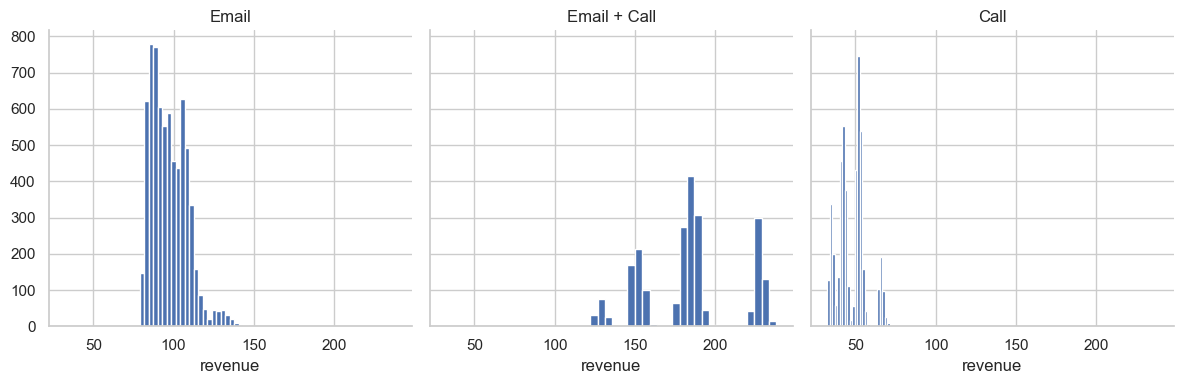

In [16]:
# Because there is a significant relationship between 'sales_method' and 'revenue_category', we can not easily drop
# missing values. In such cases, simply dropping missing values may introduce bias into your analysis.

import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a facet grid using seaborn
g = sns.FacetGrid(df_filtered, col="sales_method", col_wrap=3, height=4)

# Map a histogram for 'revenue' onto the grid
g.map(plt.hist, "revenue", bins=25)

# Add titles
g.set_titles("{col_name}")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



In [17]:
# When the distribution of revenue for each sales method is not normal, it's generally advisable to use the median for imputation rather than the mean.

# Function to perform stratified imputation
def stratified_imputation(group):
    # Calculate median of 'revenue' within each group
    median_revenue = group['revenue'].median()
    # Impute missing values with the median within each group
    group['revenue'] = group['revenue'].fillna(median_revenue)
    
    return group

# Group the DataFrame by 'sales_method' and apply stratified imputation
df_imputed = df_filtered.groupby('sales_method').apply(stratified_imputation)

# Check if there are still any missing values in 'revenue' column
missing_values = df_imputed['revenue'].isnull().sum()
print("Number of missing values after imputation:", missing_values)


Number of missing values after imputation: 0


In [18]:
df_ready = df_imputed.reset_index(drop=True)
df_ready

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state,revenue_category
0,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin,Not_Null
1,6,Call,6489e678-40f2-4fed-a48e-d0dff9c09205,13,65.01,10,24,Mississippi,Not_Null
2,5,Call,56491dae-bbe7-49f0-a651-b823a01103d8,11,53.82,7,23,Missouri,Not_Null
3,2,Call,c20ab049-cbac-4ba7-8868-310aa89e0549,9,45.42,2,23,New York,Not_Null
4,5,Call,0b026b91-fe12-4af0-86f9-387ba81c8fdb,11,53.42,2,30,Maryland,Not_Null
...,...,...,...,...,...,...,...,...,...
14993,4,Email + Call,e599ac4d-4634-49a6-b373-04c021d3a1ab,12,180.71,9,28,South Carolina,Not_Null
14994,3,Email + Call,86756cf2-5ad6-4fc8-8d65-557e4c946174,10,149.12,4,24,Kentucky,Not_Null
14995,2,Email + Call,b5c6d6e0-1237-4785-b088-17064d44d366,10,149.57,1,30,Virginia,Not_Null
14996,5,Email + Call,cd9e6945-ae21-4bed-a6cf-f0302e6c4795,12,184.74,1,34,New York,Null


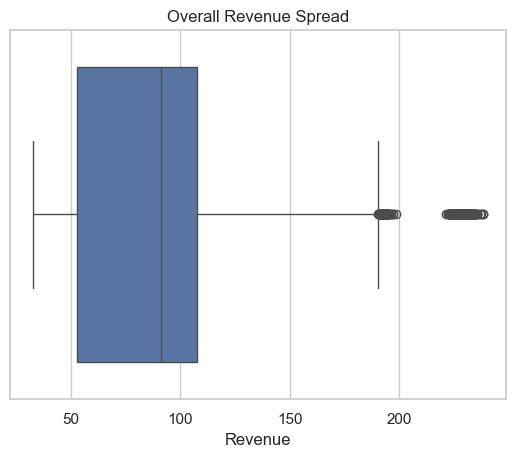

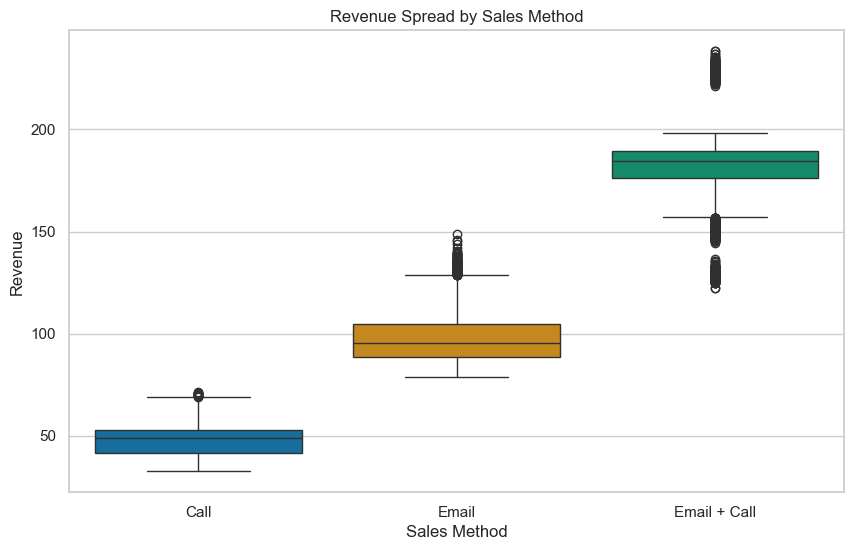

In [19]:
# Define a color palette for the box plots

# Example colors
# palette = ["#87CEFA", "#FF8D21", "#32CD32"] 

# Overall revenue spread
sns.boxplot(data=df_ready, x='revenue')
plt.title('Overall Revenue Spread')
plt.xlabel('Revenue')
plt.show()

# Revenue spread for each sales method
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ready, x='sales_method', y='revenue', hue='sales_method', palette='colorblind')
plt.title('Revenue Spread by Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Revenue')
plt.show()


In [20]:
# Median revenue for each sales method
median_df = df_ready.groupby('sales_method')['revenue'].median()

# To display the resulting DataFrame
print(median_df)

sales_method
Call             49.05
Email            95.58
Email + Call    184.74
Name: revenue, dtype: float64


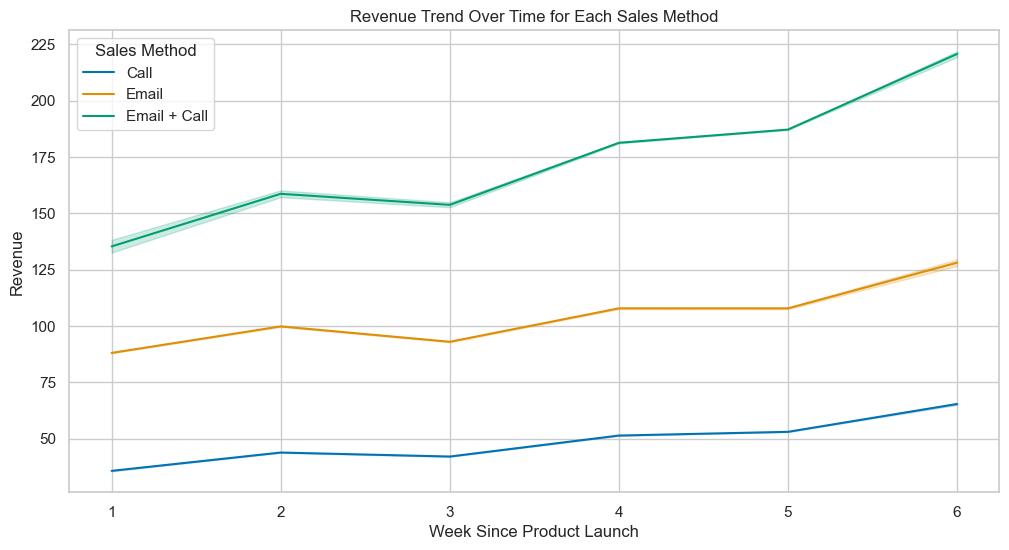

In [21]:
# To analyze the difference in revenue over time for each sales method, we can create line plots showing the trend of revenue over the weeks since 
# the product launch

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot revenue over time for each sales method
sns.lineplot(data=df_ready, x='week', y='revenue', hue='sales_method', palette='colorblind')

# Add title and labels
plt.title('Revenue Trend Over Time for Each Sales Method')
plt.xlabel('Week Since Product Launch')
plt.ylabel('Revenue')

# Show the plot
plt.legend(title='Sales Method')
plt.show()


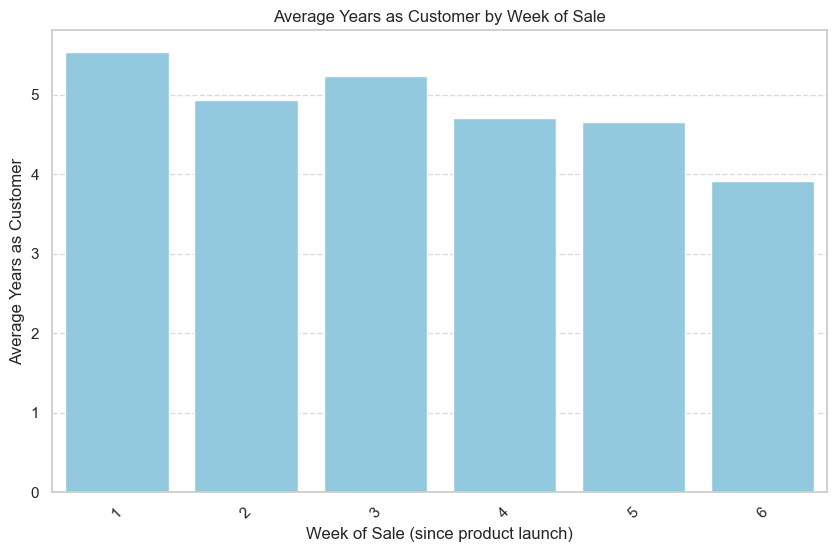

In [22]:
# Group the data by week and calculate the average years_as_customer for each week
avg_years_by_week = df_ready.groupby('week')['years_as_customer'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_years_by_week, x='week', y='years_as_customer', color='skyblue')
plt.title('Average Years as Customer by Week of Sale')
plt.xlabel('Week of Sale (since product launch)')
plt.ylabel('Average Years as Customer')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [23]:
# Calculate the correlation between week and years_as_customer
correlation = df_ready['week'].corr(df_ready['years_as_customer'])

# Print the correlation
print("Correlation between week and years_as_customer:", correlation)


Correlation between week and years_as_customer: -0.08268829695786738


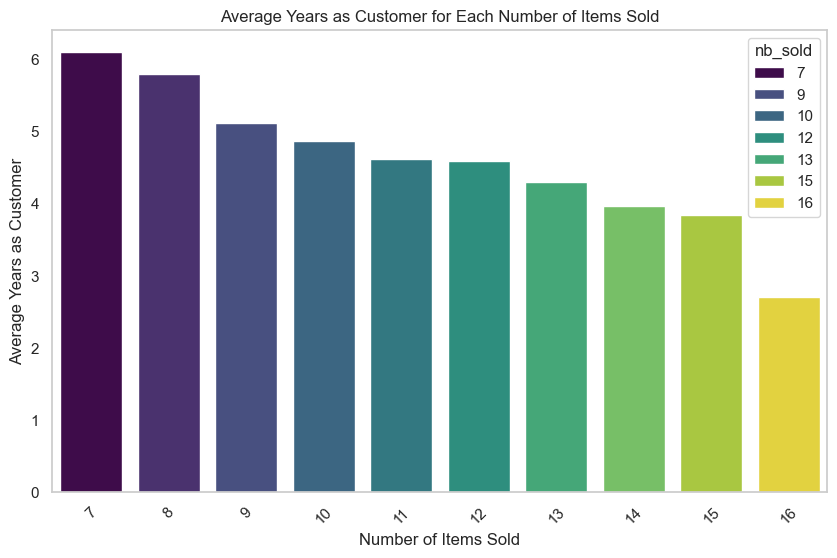

In [24]:
# Calculate the average years as customer for each nb_sold group
avg_years_per_nb_sold = df_ready.groupby('nb_sold')['years_as_customer'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_years_per_nb_sold, x='nb_sold', y='years_as_customer', hue='nb_sold', palette='viridis')
plt.title('Average Years as Customer for Each Number of Items Sold')
plt.xlabel('Number of Items Sold')
plt.ylabel('Average Years as Customer')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines for y-axis
plt.show()


In [25]:
# To calculate the correlation between years_as_customer and nb_sold, you can use the corr() function in pandas.

# Calculate the correlation between years_as_customer and nb_sold
correlation = df_ready['years_as_customer'].corr(df_ready['nb_sold'])

# Print the correlation
print("Correlation between years_as_customer and nb_sold:", correlation)


Correlation between years_as_customer and nb_sold: -0.09972786463847651


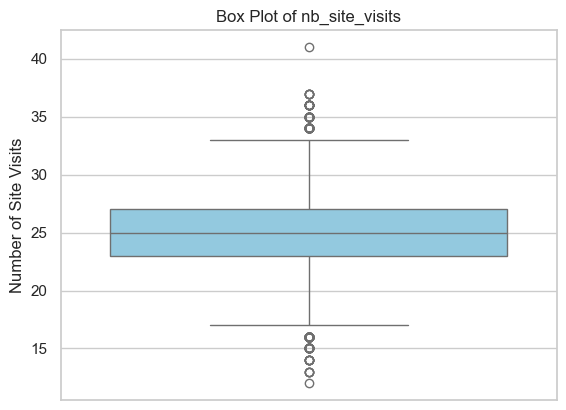

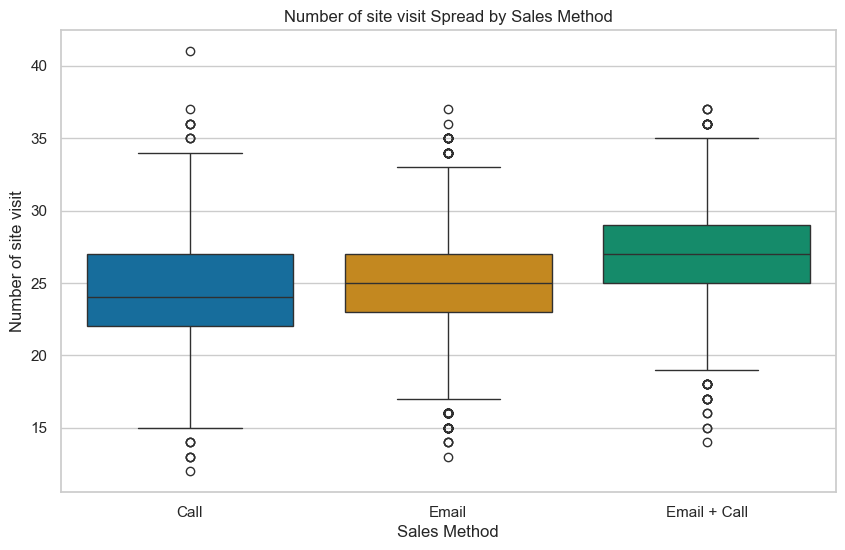

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Overall number of site visit

# Create the box plot
sns.boxplot(data=df_ready, y='nb_site_visits', color='skyblue')

# Set the title and labels
plt.title('Box Plot of nb_site_visits')
plt.ylabel('Number of Site Visits')

# Show the plot
plt.show()


# Number of site visit for each sales method

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_ready, x='sales_method', y='nb_site_visits', hue='sales_method', palette='colorblind')
plt.title('Number of site visit Spread by Sales Method')
plt.xlabel('Sales Method')
plt.ylabel('Number of site visit')
plt.show()


In [27]:
# Count the number of customers who visited more than 40 times
num_customers_visited_more_than_40 = len(df_ready[df_ready['nb_site_visits'] > 40])

print("Number of customers who visited more than 40 times:", num_customers_visited_more_than_40)


Number of customers who visited more than 40 times: 1


In [28]:
# Group the data by state and sum the revenue for each state
revenue_by_state = df_ready.groupby('state')['revenue'].sum().reset_index()

# Sort the states based on their total revenue
revenue_by_state_sorted = revenue_by_state.sort_values(by='revenue', ascending=False)

# Get the top 5 states by revenue
top_5_states_by_revenue = revenue_by_state_sorted.head(5)

print("Top 5 states by revenue:")
print(top_5_states_by_revenue)


Top 5 states by revenue:
         state    revenue
4   California  176729.57
42       Texas  114691.45
31    New York   90651.87
8      Florida   86781.53
12    Illinois   57579.82


In [29]:
# Group by 'state' and count missing values in 'revenue' column
missing_values_by_state = df[df['revenue'].isnull()].groupby('state').size().reset_index(name='missing_count')
missing_values_by_state = missing_values_by_state.sort_values(by='missing_count', ascending=False)
print(missing_values_by_state)


             state  missing_count
4       California            133
42           Texas             78
8          Florida             78
31        New York             66
34            Ohio             46
37    Pennsylvania             45
12        Illinois             41
21        Michigan             32
41       Tennessee             32
29      New Jersey             32
32  North Carolina             29
9          Georgia             29
13         Indiana             27
46      Washington             26
2          Arizona             26
45        Virginia             26
24        Missouri             25
20   Massachusetts             24
48       Wisconsin             18
5         Colorado             18
19        Maryland             18
17       Louisiana             17
22       Minnesota             17
36          Oregon             15
3         Arkansas             14
15          Kansas             13
35        Oklahoma             12
0          Alabama             12
6      Connect

In [30]:
# Group by 'state' and count missing values in 'revenue' column
missing_values_by_state = df[df['revenue'].isnull()].groupby('state').size().reset_index(name='missing_count')

# Calculate total records for each state
total_records_by_state = df.groupby('state').size().reset_index(name='total_count')

# Merge the two DataFrames on 'state'
missing_values_by_state = missing_values_by_state.merge(total_records_by_state, on='state')

# Calculate percentage of missing values for each state
missing_values_by_state['percentage_missing'] = (missing_values_by_state['missing_count'] / missing_values_by_state['total_count']) * 100

missing_values_by_state = missing_values_by_state.sort_values(by='percentage_missing', ascending = False)

print(missing_values_by_state)


             state  missing_count  total_count  percentage_missing
7         Delaware              7           34           20.588235
33    North Dakota              5           30           16.666667
1           Alaska              5           40           12.500000
3         Arkansas             14          132           10.606061
28   New Hampshire              5           53            9.433962
47   West Virginia              8           85            9.411765
41       Tennessee             32          340            9.411765
15          Kansas             13          142            9.154930
8          Florida             78          904            8.628319
20   Massachusetts             24          294            8.163265
34            Ohio             46          566            8.127208
2          Arizona             26          321            8.099688
24        Missouri             25          311            8.038585
5         Colorado             18          230            7.82

# Metric

Average Revenue per Customer Visit is a metric that measures the average amount of revenue generated by each visit to the company's website. It helps in understanding the effectiveness of the company's online sales strategy and the value derived from each interaction with customers on the website.

How to Use the Metric:

    Monitor Trends: Track the average revenue per customer visit over time to identify trends and patterns. Increasing trends may indicate improvements in online sales strategies or customer engagement, while decreasing trends may signal areas for improvement.

    Benchmarking: Compare the average revenue per visit against industry benchmarks or competitors' performance to assess the company's competitiveness and identify areas for improvement.

    Performance Evaluation: Use the metric to evaluate the effectiveness of marketing campaigns, website optimizations, or changes in sales strategies. Identify high-performing periods and factors contributing to success.

In [31]:
total_revenue = df_ready['revenue'].sum()
total_visits = df_ready['nb_site_visits'].sum()
average_revenue_per_visit = total_revenue / total_visits
print("Initial Average Revenue per Visit:", average_revenue_per_visit)

Initial Average Revenue per Visit: 3.824152241657151


## segmented by different sales methods. 

It provides insights into the effectiveness of each sales method in converting website visits into revenue and helps in identifying which sales methods are most successful in driving revenue per visit.

In [32]:
# Calculate total revenue and total visits for each sales method
total_revenue_by_method = df_ready.groupby('sales_method')['revenue'].sum()
total_visits_by_method = df_ready.groupby('sales_method')['nb_site_visits'].sum()

# Calculate average revenue per visit for each sales method
average_revenue_per_visit_by_method = total_revenue_by_method / total_visits_by_method
print("Initial Average Revenue per Visit (by Sales Method):")
print(average_revenue_per_visit_by_method)


Initial Average Revenue per Visit (by Sales Method):
sales_method
Call            1.951001
Email           3.919088
Email + Call    6.865501
dtype: float64
